<a href="https://colab.research.google.com/github/NyxLumen/Encephlo/blob/main/encephlo3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random


In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")


In [4]:
from google.colab import files
files.upload()

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip -d /content/dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0724.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0725.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0726.jpg  
  in

In [5]:
TRAIN_PATH = "/content/dataset/Training"
TEST_PATH  = "/content/dataset/Testing"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    validation_split=0.2
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [7]:
train_ds = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    subset="training"
)

val_ds = val_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    subset="validation"
)

class_names = list(train_ds.class_indices.keys())
print("Classes:", class_names)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [8]:
def build_model():
    base_model = tf.keras.applications.EfficientNetV2S(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
    )

    base_model.trainable = True

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(4)(x)  # logits

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
    return model

model = build_model()
model.summary()


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        648 │ rescaling[0][0]   │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 112, 112,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 20,336,484 (77.58 MB)

 Trainable params: 20,182,612 (76.99 MB)

 Non-trainable params: 153,872 (601.06 KB)

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True
    ),
    metrics=["accuracy"]
)

In [12]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        patience=2,
        factor=0.3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "brain_tumor_best.keras",
        monitor="val_accuracy",
        save_best_only=True
    )
]


In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 600s 2s/step - accuracy: 0.7948 - loss: 0.5106 - val_accuracy: 0.7590 - val_loss: 0.6697 - learning_rate: 0.0010
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 63s 442ms/step - accuracy: 0.9397 - loss: 0.1687 - val_accuracy: 0.6635 - val_loss: 0.8857 - learning_rate: 0.0010
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 63s 440ms/step - accuracy: 0.9667 - loss: 0.1055 - val_accuracy: 0.4373 - val_loss: 1.6625 - learning_rate: 0.0010
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 478ms/step - accuracy: 0.9742 - loss: 0.0832 - val_accuracy: 0.9413 - val_loss: 0.2110 - learning_rate: 3.0000e-04
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 443ms/step - accuracy: 0.9899 - loss: 0.0309 - val_accuracy: 0.9115 - val_loss: 0.2764 - learning_rate: 3.0000e-04
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 486ms/step - accuracy: 0.9925 - loss: 0.0222 - val_accuracy: 0.9492 - val_loss: 0.1884 - learning_rate: 3.0000e-04
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 63s 441ms/step - acc

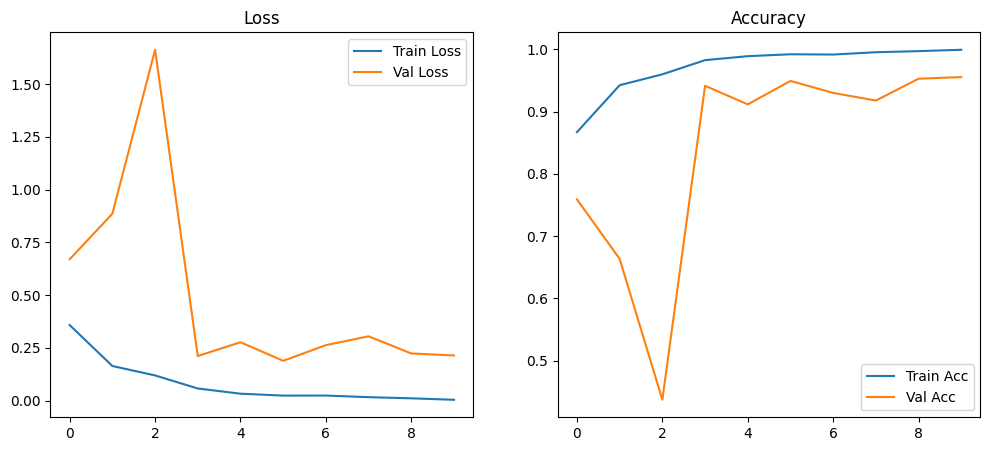

In [14]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.show()


In [21]:
model.save('trial_better.h5')

In [15]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_ds = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)


Found 1311 images belonging to 4 classes.


In [16]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9644 - loss: 0.1612
Test Accuracy: 97.71%
Test Loss: 0.1081



Detailed Predictions:
Image: Te-gl_0152.jpg - True Label: glioma - Predicted: glioma
Image: Te-gl_0189.jpg - True Label: glioma - Predicted: glioma
Image: Te-me_0245.jpg - True Label: meningioma - Predicted: meningioma
Image: Te-me_0131.jpg - True Label: meningioma - Predicted: meningioma
Image: Te-no_0141.jpg - True Label: notumor - Predicted: notumor
Image: Te-no_0364.jpg - True Label: notumor - Predicted: notumor
Image: Te-pi_0289.jpg - True Label: pituitary - Predicted: pituitary
Image: Te-pi_0056.jpg - True Label: pituitary - Predicted: pituitary


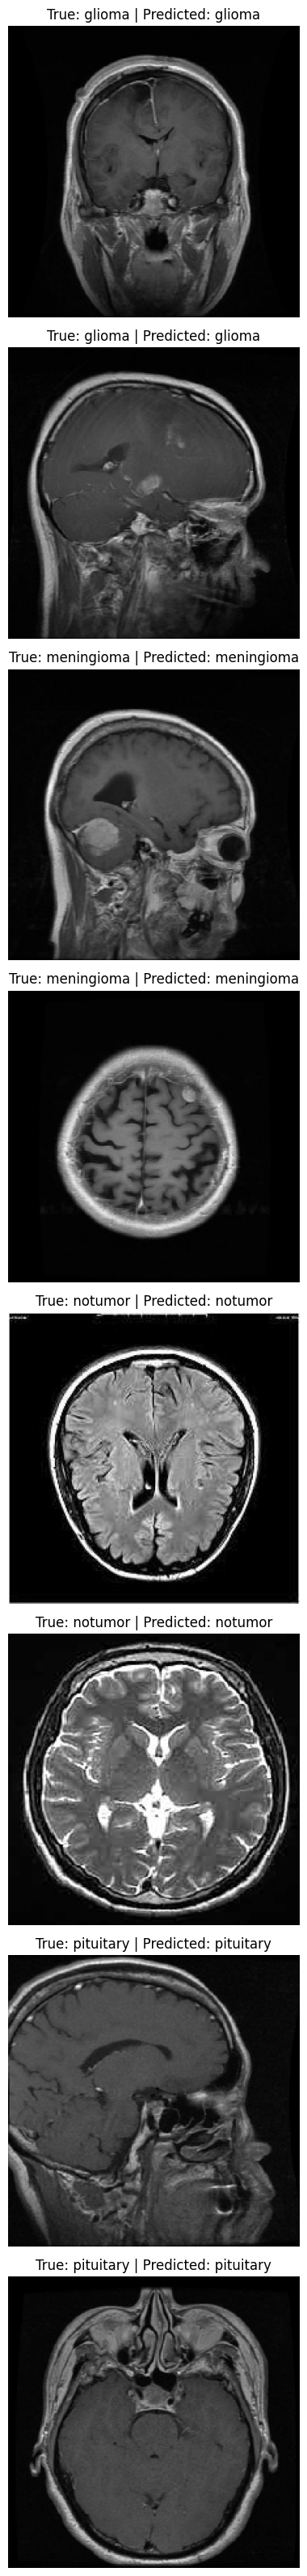

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
def predict_and_visualize_tf(model, test_ds, class_names, samples_per_class=2):
    # Collect file paths and labels
    filepaths = np.array(test_ds.filepaths)
    labels = test_ds.classes

    # Group indices by class
    class_to_indices = {i: [] for i in range(len(class_names))}
    for idx, label in enumerate(labels):
        class_to_indices[label].append(idx)

    selected_indices = []
    for class_idx, indices in class_to_indices.items():
        selected_indices.extend(
            random.sample(indices, min(samples_per_class, len(indices)))
        )

    print("\nDetailed Predictions:")
    plt.figure(figsize=(12, 4 * len(selected_indices)))

    for i, idx in enumerate(selected_indices):
        # Load image
        img_path = filepaths[idx]
        img = tf.keras.preprocessing.image.load_img(
            img_path, target_size=(224, 224)
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        logits = model.predict(img_array, verbose=0)
        probs = tf.nn.softmax(logits, axis=1)
        pred_idx = np.argmax(probs)

        true_label = class_names[labels[idx]]
        pred_label = class_names[pred_idx]

        # Print (PyTorch-style)
        print(
            f"Image: {os.path.basename(img_path)} - "
            f"True Label: {true_label} - Predicted: {pred_label}"
        )

        # Plot
        plt.subplot(len(selected_indices), 1, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label} | Predicted: {pred_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

predict_and_visualize_tf(
    model,
    test_ds,
    class_names,
    samples_per_class=2
)

